In [1]:
import torch
import torchvision

from models import LFADS
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

np = torch._np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [3]:
seed = 250
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    data_dict = generate_lorenz_data(N_cells=30, N_inits=65, N_trials=20, N_steps=200, N_stepsinbin=2, dt_lorenz=0.015, dt_spike = 1./20, base_firing_rate= 1.0, save=True, seed=250)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('./parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] += '_localtest'
save_parameters(hyperparams, path=None)

hyperparams

{'betas': (0.9, 0.99),
 'clip_val': 5.0,
 'dataset_name': 'lorenz',
 'datatype': 'spikes',
 'epsilon': 0.1,
 'factors_dim': 3,
 'g0_encoder_dim': 64,
 'g0_prior_kappa': 0.1,
 'g0_prior_var_max': 0.1,
 'g0_prior_var_min': 0.1,
 'g_dim': 64,
 'keep_prob': 0.95,
 'kernel_dim': 20,
 'kl_weight_min': 0.0,
 'kl_weight_schedule_dur': 1600,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 250,
 'l2_weight_min': 0.0,
 'l2_weight_schedule_dur': 1600,
 'l2_weight_schedule_start': 0.0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'norm_factors': True,
 'run_name': 'poisson_localtest',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 0,
 'u_prior_kappa': 0.1,
 'use_weight_schedule_fn': True}

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 2394


In [6]:
model.load_checkpoint('recent')

In [13]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=65, use_tensorboard=False, health_check=False)

Beginning training...
Epoch:    1, Step:    16, training loss: 1255.578, validation loss: 1433.956
Epoch:    2, Step:    32, training loss: 1240.143, validation loss: 1345.507
Epoch:    3, Step:    48, training loss: 1231.079, validation loss: 1252.499
Epoch:    4, Step:    64, training loss: 1226.208, validation loss: 1241.464
Epoch:    5, Step:    80, training loss: 1224.343, validation loss: 1239.194
Epoch:    6, Step:    96, training loss: 1222.943, validation loss: 1237.069
Epoch:    7, Step:   112, training loss: 1221.871, validation loss: 1241.644
Epoch:    8, Step:   128, training loss: 1219.371, validation loss: 1246.107
Epoch:    9, Step:   144, training loss: 1215.621, validation loss: 1241.561
Epoch:   10, Step:   160, training loss: 1212.549, validation loss: 1242.801
Epoch:   11, Step:   176, training loss: 1211.010, validation loss: 1234.899
Epoch:   12, Step:   192, training loss: 1209.260, validation loss: 1231.473
Epoch:   13, Step:   208, training loss: 1202.906, val

In [7]:
model.load_checkpoint('best')

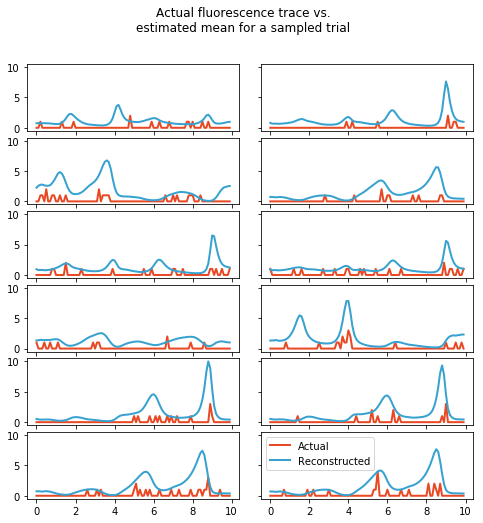

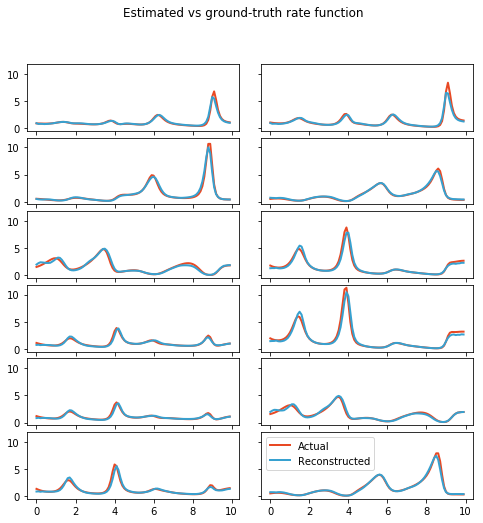

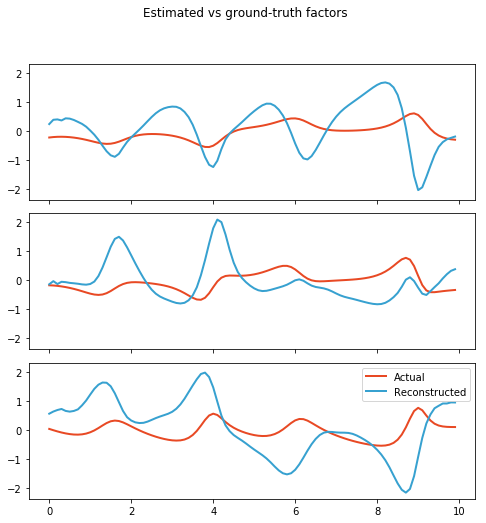

In [8]:
fig_dict = model.plot_summary(data=valid_data, truth=valid_truth)

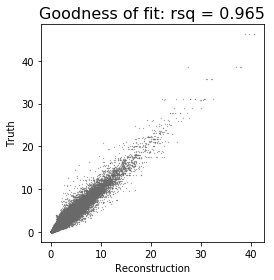

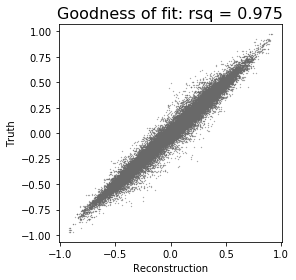

In [9]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

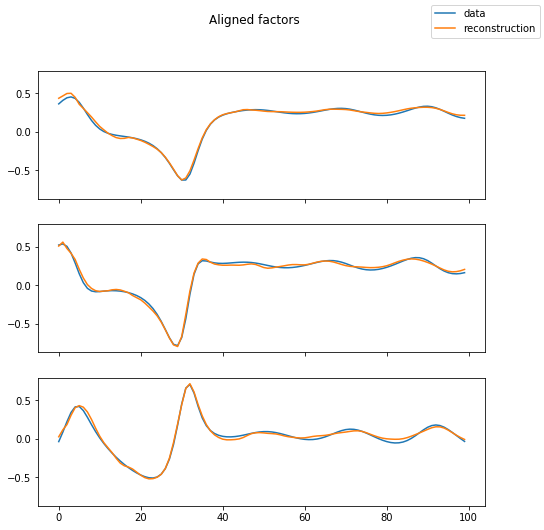

In [10]:
fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1, sharex=True, sharey=True)
for ix in range(3):
    plt.sca(axs[ix])
    plt.plot(data_dict['valid_latent'][0, :100, ix])
    plt.plot(results_dict['factors']['aligned'][:100, ix])
    
fig.suptitle('Aligned factors')
fig.legend(['data', 'reconstruction'])

## Inspecting trained model 

In [3]:
seed = 600
system = 'chaotic-rnn'
if os.path.exists('./synth_data/%s_%s'%(system, seed)):
    data_dict = read_data('./synth_data/%s_%s'%(system, seed))
else:
    from synthetic_data import generate_chaotic_rnn_data
    param_dict = yaml.load(open('./synth_data/%s_params.yaml'%system, 'r'), Loader=yaml.FullLoader)
    data_dict = generate_chaotic_rnn_data(Ncells=param_dict['cells'],
                                          Ninits=param_dict['inits'],
                                          Ntrial=param_dict['trials'],
                                          Nsteps=param_dict['steps'],
#                                         Nstepsinbin=param_dict['steps_in_bin'],
                                          dt_rnn=param_dict['dt_sys'],
                                          dt_spike = param_dict['dt_spike'],
                                          maxRate= param_dict['rate_scale'],
                                          save=False,
                                          seed=seed)

    
    
# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates']}

valid_truth = {'rates'  : data_dict['valid_rates']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([3200, 100, 50])
Number of datapoints = 16000000


In [4]:
hyperparams = load_parameters('parameters/parameters_%s_spikes.yaml'%system)
hyperparams['run_name'] = 'poisson_%s%i_f20_g1200_eg1128_u1_c1128_ec1128_191125_localtest'%(system, seed)

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)
# model.load_checkpoint('best')
# model.epochs

Random seed: 392


In [11]:
model.gru_generator.fc_h_ru.weight.std()

tensor(0.0705, device='cuda:0', grad_fn=<StdBackward0>)

In [10]:
1/(np.sqrt(400))

0.05

In [12]:
total_params = 0
for ix, (name, param) in enumerate(model.named_parameters()):
    print(ix, name, list(param.shape), param.numel(), param.requires_grad)
    total_params += param.numel()
    
print('Total parameters: %i'%total_params)

0 efgen_g0_init [128] 128 True
1 ebgen_g0_init [128] 128 True
2 efcon_c_init [128] 128 True
3 ebcon_c_init [128] 128 True
4 c_init [128] 128 True
5 g0_prior_mu [64] 64 True
6 u_prior_logtau [1] 1 True
7 u_prior_logkappa [1] 1 True
8 gru_Egen_g0.weight_ih_l0 [384, 50] 19200 True
9 gru_Egen_g0.weight_hh_l0 [384, 128] 49152 True
10 gru_Egen_g0.bias_ih_l0 [384] 384 True
11 gru_Egen_g0.bias_hh_l0 [384] 384 True
12 gru_Egen_g0.weight_ih_l0_reverse [384, 50] 19200 True
13 gru_Egen_g0.weight_hh_l0_reverse [384, 128] 49152 True
14 gru_Egen_g0.bias_ih_l0_reverse [384] 384 True
15 gru_Egen_g0.bias_hh_l0_reverse [384] 384 True
16 gru_Econ_c.weight_ih_l0 [384, 50] 19200 True
17 gru_Econ_c.weight_hh_l0 [384, 128] 49152 True
18 gru_Econ_c.bias_ih_l0 [384] 384 True
19 gru_Econ_c.bias_hh_l0 [384] 384 True
20 gru_Econ_c.weight_ih_l0_reverse [384, 50] 19200 True
21 gru_Econ_c.weight_hh_l0_reverse [384, 128] 49152 True
22 gru_Econ_c.bias_ih_l0_reverse [384] 384 True
23 gru_Econ_c.bias_hh_l0_reverse [384] 

In [13]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=128, use_tensorboard=True, health_check=True)

Beginning training...
Epoch:    1, Step:    25, training loss: 2557.217, validation loss: 2610.053, Runtime: 17.2304 secs
Epoch:    2, Step:    50, training loss: 2208.789, validation loss: 2479.728, Runtime: 17.0755 secs
Epoch:    3, Step:    75, training loss: 2140.418, validation loss: 2327.982, Runtime: 17.3312 secs
Epoch:    4, Step:   100, training loss: 2118.082, validation loss: 2299.716, Runtime: 18.5046 secs
Epoch:    5, Step:   125, training loss: 2106.918, validation loss: 2264.256, Runtime: 17.5414 secs
Epoch:    6, Step:   150, training loss: 2101.052, validation loss: 2238.768, Runtime: 17.4161 secs
Epoch:    7, Step:   175, training loss: 2094.568, validation loss: 2230.944, Runtime: 17.3690 secs
Epoch:    8, Step:   200, training loss: 2086.985, validation loss: 2213.271, Runtime: 16.8770 secs
Epoch:    9, Step:   225, training loss: 2083.442, validation loss: 2219.212, Runtime: 16.9674 secs
Epoch:   10, Step:   250, training loss: 2083.308, validation loss: 2194.288, 

In [16]:
model.load_checkpoint('best')

{'factors': <Figure size 576x576 with 20 Axes>,
 'inputs': <Figure size 576x108 with 1 Axes>,
 'ix': 499,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth_rates': <Figure size 576x576 with 12 Axes>}

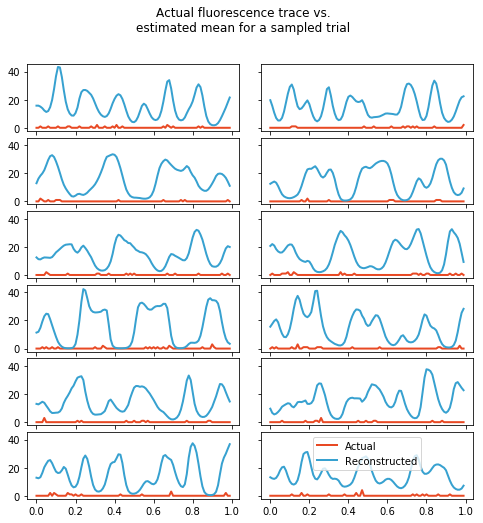

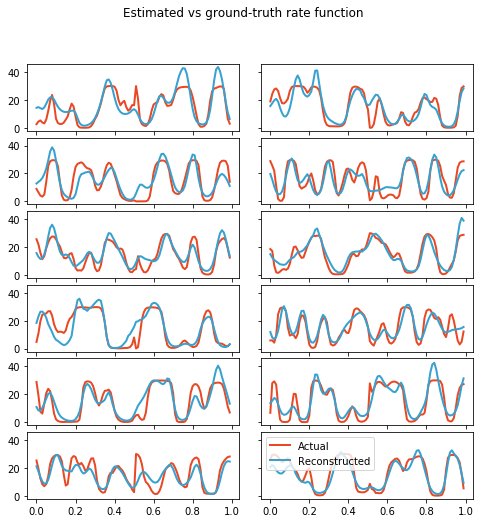

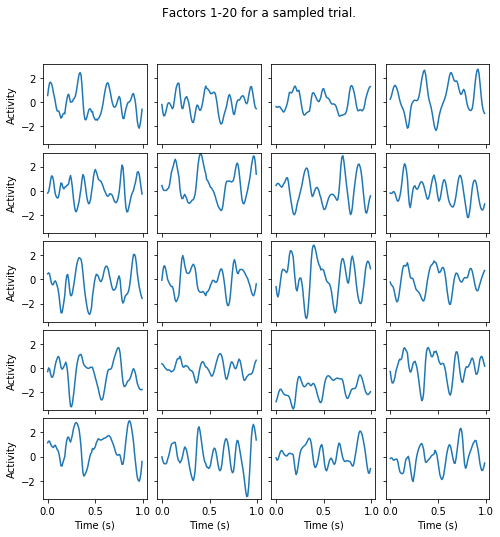

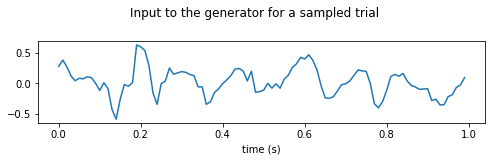

In [17]:
model.plot_summary(valid_data, valid_truth)

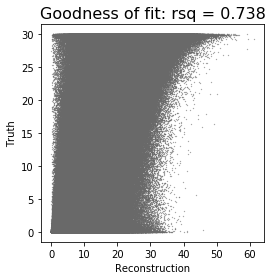

In [18]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)